In [ ]:
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
!cat /root/.ssh/id_rsa.pub

In [ ]:
!ssh -T git@github.com
!git config --global user.email "justin.deschenauxy@epfl.com"
!git config --global user.name "Justin-Collab"
!git clone git@github.com:deschena/colab_unet_train.git
!mv colab_unet_train/* .
from google.colab import drive
drive.mount('/content/gdrive')
!nvidia-smi -L

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os, sys, io, random
from PIL import Image
from collections import OrderedDict

from datasets.AugmDataset import AugmDataset
from models.Unet import Unet
from models.DenseUnet import DenseUnet
from utils import *
%matplotlib inline

# Model Selection

In [ ]:
# For reproducibility
SEED = 987897
np.random.seed(SEED)
random.seed(SEED)
torch.random.manual_seed(SEED)
print("All random seeds set")

In [ ]:
device = "cuda"
batch_size=16
root_path = "datasets/augmented_dataset/"
train_name = "msel_train/"
valid_name = "msel_valid/"
test_name = "msel_test/"

test_set = AugmDataset(root_dir=root_path, name=test_name)
val_loader = DataLoader(test_set, batch_size=2 * batch_size, shuffle=False, num_workers=8)

In [ ]:
def train_net(net, train_name, valid_name, alpha, beta, seed=999, max_epoch=50, net_name="DEFAULT", patience=4, verbose=True, batch_size=16):
    torch.random.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    device = "cuda"
    root_path = "datasets/augmented_dataset/"

    bce = nn.BCELoss()
    criterion = composite_loss(bce, alpha=alpha, beta=beta, )
    
    train_set = AugmDataset(root_dir=root_path, name=train_name)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=batch_size)    

    validation_set = AugmDataset(root_dir=root_path,name=valid_name)
    validation_loader = DataLoader(validation_set, batch_size=2*batch_size, shuffle=False, num_workers=2*batch_size)
    
    # Send to GPU, prepare optimizer and learning rate scheduler
    net.to(device)
    optimizer = optim.Adam(net.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=patience, verbose=verbose)
    
    validation_loss = []
    training_loss = []
    loss = -1
    best_current_loss = -1
    
    for epoch in range(max_epoch):
        net.train()
        for batch_train, batch_gt in train_loader:
            
            # Send data to gpu
            batch_train = batch_train.to(device)
            batch_gt = batch_gt.to(device)
            
            # Clear accumulated gradients & compute prediction
            optimizer.zero_grad()
            output = net(batch_train)
            # Compute loss, gradient & update parameters
            loss = criterion(output, batch_gt)
            loss.backward()
            optimizer.step()
            
        # After each epoch, compute & save loss on training and validation sets
        v_perf = validation_perf(net, validation_loader)
        validation_loss.append(v_perf)
        training_loss.append(loss)
        # Check if scheduler must decrease learning rate
        scheduler.step(v_perf)
        if v_perf > best_current_loss:
            # Save best net
            torch.save(net.state_dict(), f"/content/gdrive/My Drive/ML files/loss_experiment/{net_name}.pth")
            v_perf = best_current_loss
        if verbose and epoch % 10 == 0:
            print(f"{epoch} epochs elapsed")
            
    return training_loss, validation_loss

#### Train the models
**Models considered**:
1. Standard Unet
2. Attention Unet (channel attention)
3. Attention Unet (pixel attention)
4. Dense Unet
5. Dense Attention Unet (channel attention)
6. Dense Attention Unet (pixel attention)

**Note**: all those flavours of u-net have the same structure: the skip connections in the middle have the same number of channels. The difference comes from the feature "generation" in the descending path: dense unet uses dense blocks instead of simple convolutions on the standard unet.

### Training the models
We choose to conduct this experiment on the simler architecture we have: the original U-net. The reason behind this choice is that it is the one with the least parameters, hence is faster to train. We are aware that the parameters might be exactly the same in case we use a Dense Unet, or if we add an attention mechanism. However, we believe the change should not be very high.

In [ ]:
%%time
net1 = Unet()
net1_tr, net1_val = train_net(net1, train_name, valid_name, alpha=1, beta=0.0001, net_name="unet1", batch_size=16)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet1_tr_loss", net1_tr)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet1_val_loss", net1_val)

In [ ]:
%%time
net2 = Unet()
net2_tr, net2_val = train_net(net2, train_name, valid_name, alpha=1, beta=0.001, net_name="unet2", batch_size=16)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet2_tr_loss", net2_tr)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet2_val_loss", net2_val)

In [ ]:
%%time
net3 = Unet()
net3_tr, net3_val = train_net(net3, train_name, valid_name, alpha=1, beta=0.01, net_name="unet3", batch_size=16)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet3_tr_loss", net3_tr)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet3_val_loss", net3_val)

In [ ]:
%%time
net4 = Unet()
net4_tr, net4_val = train_net(net4, train_name, valid_name, alpha=1, beta=0.1, net_name="unet4", batch_size=16)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet4_tr_loss", net4_tr)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet4_val_loss", net4_val)

In [ ]:
%%time
net5 = Unet()
net5_tr, net5_val = train_net(net5, train_name, valid_name, alpha=0, beta=1, net_name="unet5", batch_size=16)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet5_tr_loss", net5_tr)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet5_val_loss", net5_val)

In [ ]:
%%time
net6 = Unet()
net6_tr, net6_val = train_net(net6, train_name, valid_name, alpha=1, beta=0, net_name="unet6", batch_size=16)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet6_tr_loss", net6_tr)
np.save(f"/content/gdrive/My Drive/ML files/loss_experiment/unet6_val_loss", net6_val)

### Evaluating the performance of each loss
After training those 6 U-nets, we wanted to evaluate their performance with respect to the different losses. Therefore, we evaluate their performance on the test set (20% of the original data)

In [2]:
def load_unet(name):
    path = "experiments/loss_experiment/" + name + ".pth"
    params = torch.load(path)
    net = Unet()
    net.load_state_dict(params)
    net.eval()
    net.to("cuda")
    return net

In [3]:
def model_on_test_set(name, dataset_path, dataset_name):
    dataset = AugmDataset(root_dir=dataset_path,name=dataset_name)
    loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)
    net = load_unet(name)
    res = validation_perf(net, loader)
    return res

In [4]:
perf1 = model_on_test_set("unet1", "datasets/augmented_dataset/", "msel_test/")
perf2 = model_on_test_set("unet2", "datasets/augmented_dataset/", "msel_test/")
perf3 = model_on_test_set("unet3", "datasets/augmented_dataset/", "msel_test/")
perf4 = model_on_test_set("unet4", "datasets/augmented_dataset/", "msel_test/")
perf5 = model_on_test_set("unet5", "datasets/augmented_dataset/", "msel_test/")
perf6 = model_on_test_set("unet6", "datasets/augmented_dataset/", "msel_test/")

In [5]:
print(perf1)
print(perf2)
print(perf3)
print(perf4)
print(perf5)
print(perf6)

0.8448053498721457
0.8356371938157967
0.8550751842491513
0.8541848943174892
0.8565021327321677
0.8265824633880856


Surprisingly, the composite loss is supersed by the simple one ! Hopefully we tested...

In [12]:
val_score_1 = np.load("experiments/loss_experiment/unet1_val_loss.pth.npy", allow_pickle=True)
val_score_2 = np.load("experiments/loss_experiment/unet2_val_loss.pth.npy", allow_pickle=True)
val_score_3 = np.load("experiments/loss_experiment/unet3_val_loss.pth.npy", allow_pickle=True)
val_score_4 = np.load("experiments/loss_experiment/unet4_val_loss.pth.npy", allow_pickle=True)
val_score_5 = np.load("experiments/loss_experiment/unet5_val_loss.pth.npy", allow_pickle=True)
val_score_6 = np.load("experiments/loss_experiment/unet6_val_loss.pth.npy", allow_pickle=True)

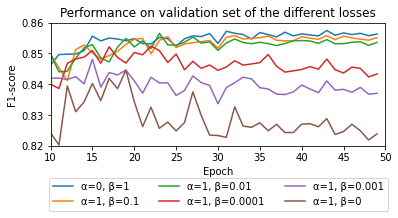

In [60]:
fig = plt.figure(figsize=(6, 3))
plt.title("Performance on validation set of the different losses")
plt.ylabel("F1-score")
plt.xlabel("Epoch")
epochs = np.arange(50)
plt.ylim((0.82, 0.86))
plt.xlim((10, 50))

plt.plot(epochs, val_score_5, label="α=0, β=1")
plt.plot(epochs, val_score_4, label="α=1, β=0.1")
plt.plot(epochs, val_score_3, label="α=1, β=0.01")
plt.plot(epochs, val_score_1, label="α=1, β=0.0001")
plt.plot(epochs, val_score_2, label="α=1, β=0.001")
plt.plot(epochs, val_score_6, label="α=1, β=0")
plt.legend(bbox_to_anchor=(-0.02, -0.22), ncol=3)
fig.subplots_adjust(bottom=0.31)
plt.savefig("perf_wrt_loss.png", dpi=300)